# **MRI Brain Alzheimer Classification - DINOv2 Model with Adversarial Attacks**

**Clone Dataset from GitHub**

In [1]:
# Clone repository from GitHub
# !git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification

# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Brain_Alzheimer_Classification


**Import Packages**

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
import gc
import subprocess

**Import Internal Functions**

In [3]:
from models import def_models
from utils import utils_funcs
from utils import optuna_search

**Device Definition**

In [4]:
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()
gc.collect()
utils_funcs.open_nvitop()

torch.cuda.is_available(): True
device: cuda:0


**Load Dataset**

In [5]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

**Normalize and Rescale the Dataset**

In [6]:
# train_set, validation_set, test_set = utils_funcs.prepare_datasets(train_set, validation_set, test_set)
# torch.cuda.empty_cache()

**Model Definition and Initialization**

In [7]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

# Load a pre-trained EfficientNet-B0 model
EfficientNet_backbone_model = torchvision.models.efficientnet_b0(pretrained=True)

# Freeze EfficientNet-B0 layers
for param in EfficientNet_backbone_model.parameters():
    param.requires_grad = False
    
# Unfreeze the last classifier layer to allow training
for param in EfficientNet_backbone_model.features[-4:].parameters():
    param.requires_grad = True

# Create EfficientNet-B4 model with FC layers before the output
model = def_models.EfficientNet(EfficientNet_backbone=EfficientNet_backbone_model, output_channels=output_channels).to(device)

**Model Statistics**

In [8]:
model_name = type(model).__name__ + '_atk'
print("Model", model_name, "statistics:")
summary(model, (input_channels, input_height, input_width))

Model EfficientNet_atk statistics:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
    

**Set Hyper-Parameters Using Optuna**

In [9]:
load_existing_hyperparams = True

if load_existing_hyperparams:
    # Load hyper-parameters (relevant if optuna has already used)
    optuna_params_path = f'./checkpoints/optuna_params/EfficientNet/EfficientNet_0.8901.json'
    with open(optuna_params_path, 'r') as file:
        hyperparams = json.load(file)
else:
    # Find optimal hyper-parameters using optuna
    torch.cuda.empty_cache()
    hyperparams = optuna_search.optuna_param_search(model_name="EfficientNet", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=10, device=device, transfer_learning=True)

print(hyperparams)

{'lr': 0.0008763123646325776, 'optimizer': 'RMSprop', 'batch_size': 256, 'scheduler': 'StepLR'}


In [10]:
# Set hyper-parameters
batch_size = hyperparams['batch_size']
learning_rate = hyperparams['lr']
optimizer_name = hyperparams['optimizer']
optimizer = getattr(torch.optim, optimizer_name)(model.fc.parameters(), lr=learning_rate)
num_epochs = 35
scheduler = hyperparams['scheduler']
scheduler = StepLR(optimizer, 10, 0.1, verbose=True) if scheduler == "StepLR" else CosineAnnealingLR(optimizer, num_epochs, verbose=True)
criterion = nn.CrossEntropyLoss()

**Create Data Loader**

In [11]:
# Test loader witch batch size of 1 (in order to perform attacks one by one)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=6, pin_memory=True)

**Load Trained Model**

In [12]:
pretrained_model_path = f"./checkpoints/EfficientNet_225106_16102024/EfficientNet_001249_17102024_train_0.0434_val_0.1027.pth"
checkpoint = torch.load(pretrained_model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

**Perform Fast Gradient Sign (FGSM) Attack**

In [13]:
accuracies = []
examples = []
epsilons = [0, .0005, .005, .05, .1, .15, .2, .25, .3]
# epsilons = [0, .0005, .005, .05]

for eps in epsilons:
    print(f"Performing attack using epsilon {eps}")
    acc, ex = utils_funcs.test_single_point_attack(model, device, testloader, 'fgsm', eps)
    accuracies.append(acc)
    examples.append(ex)

utils_funcs.print_accuracy_table(epsilons, accuracies, parameter_type ='Epsilon')

Performing attack using epsilon 0
Performing attack using epsilon 0.0005
Performing attack using epsilon 0.005
Performing attack using epsilon 0.05
Performing attack using epsilon 0.1
Performing attack using epsilon 0.15
Performing attack using epsilon 0.2
Performing attack using epsilon 0.25
Performing attack using epsilon 0.3
+---------+----------+
| Epsilon | Accuracy |
+---------+----------+
|    0    | 96.5598% |
|  0.0005 | 0.5473%  |
|  0.005  | 13.6826% |
|   0.05  | 40.7349% |
|   0.1   | 36.9820% |
|   0.15  | 25.7232% |
|   0.2   | 31.5090% |
|   0.25  | 26.5833% |
|   0.3   | 24.8632% |
+---------+----------+


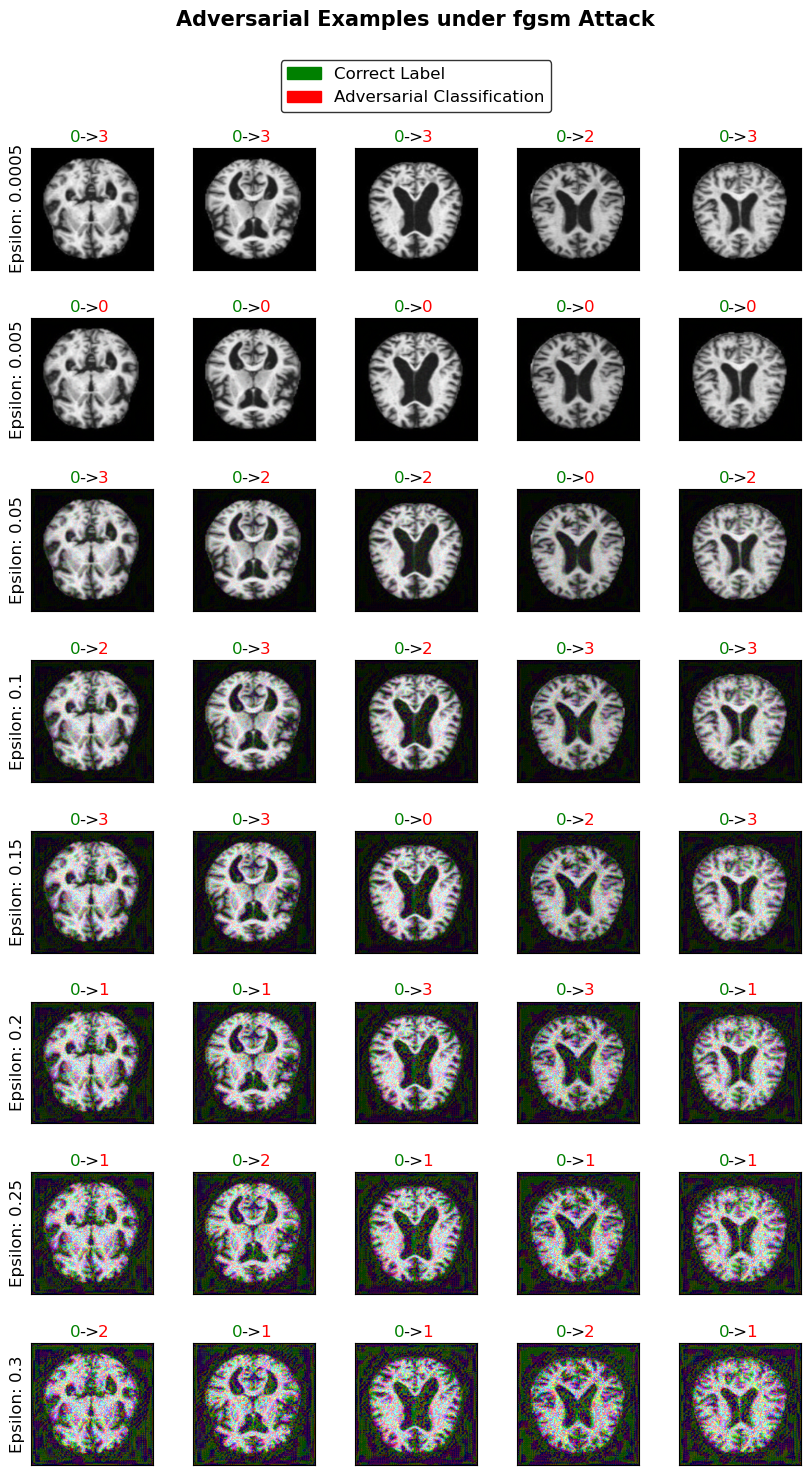

In [14]:
utils_funcs.plot_adversarial_examples(epsilons, examples, attack_name='fgsm', parameter_type = 'Epsilon')

**Perform Projected Gradient Descent (PGD) Attack**

In [15]:
accuracies = []
examples = []
epsilon = 0.0005
num_iter = 5
alphas = [0, 0.0001, 0.00001, 0.00008, 0.000001, 0.000004]


for alpha in alphas:
    print(f"Performing attack using alpha {alpha}")
    acc, ex = utils_funcs.test_single_point_attack(model, device, testloader, 'pgd', epsilon, alpha=alpha, num_iter=num_iter)
    accuracies.append(acc)
    examples.append(ex)
    torch.cuda.empty_cache()
    gc.collect()

utils_funcs.print_accuracy_table(alphas, accuracies, parameter_type ='Alpha')

Performing attack using alpha 0
Performing attack using alpha 0.0001
Performing attack using alpha 1e-05
Performing attack using alpha 8e-05
Performing attack using alpha 1e-06
Performing attack using alpha 4e-06
+--------+----------+
| Alpha  | Accuracy |
+--------+----------+
|   0    | 96.2471% |
| 0.0001 | 0.0000%  |
| 1e-05  | 21.5794% |
| 8e-05  | 0.0000%  |
| 1e-06  | 93.6669% |
| 4e-06  | 75.9187% |
+--------+----------+


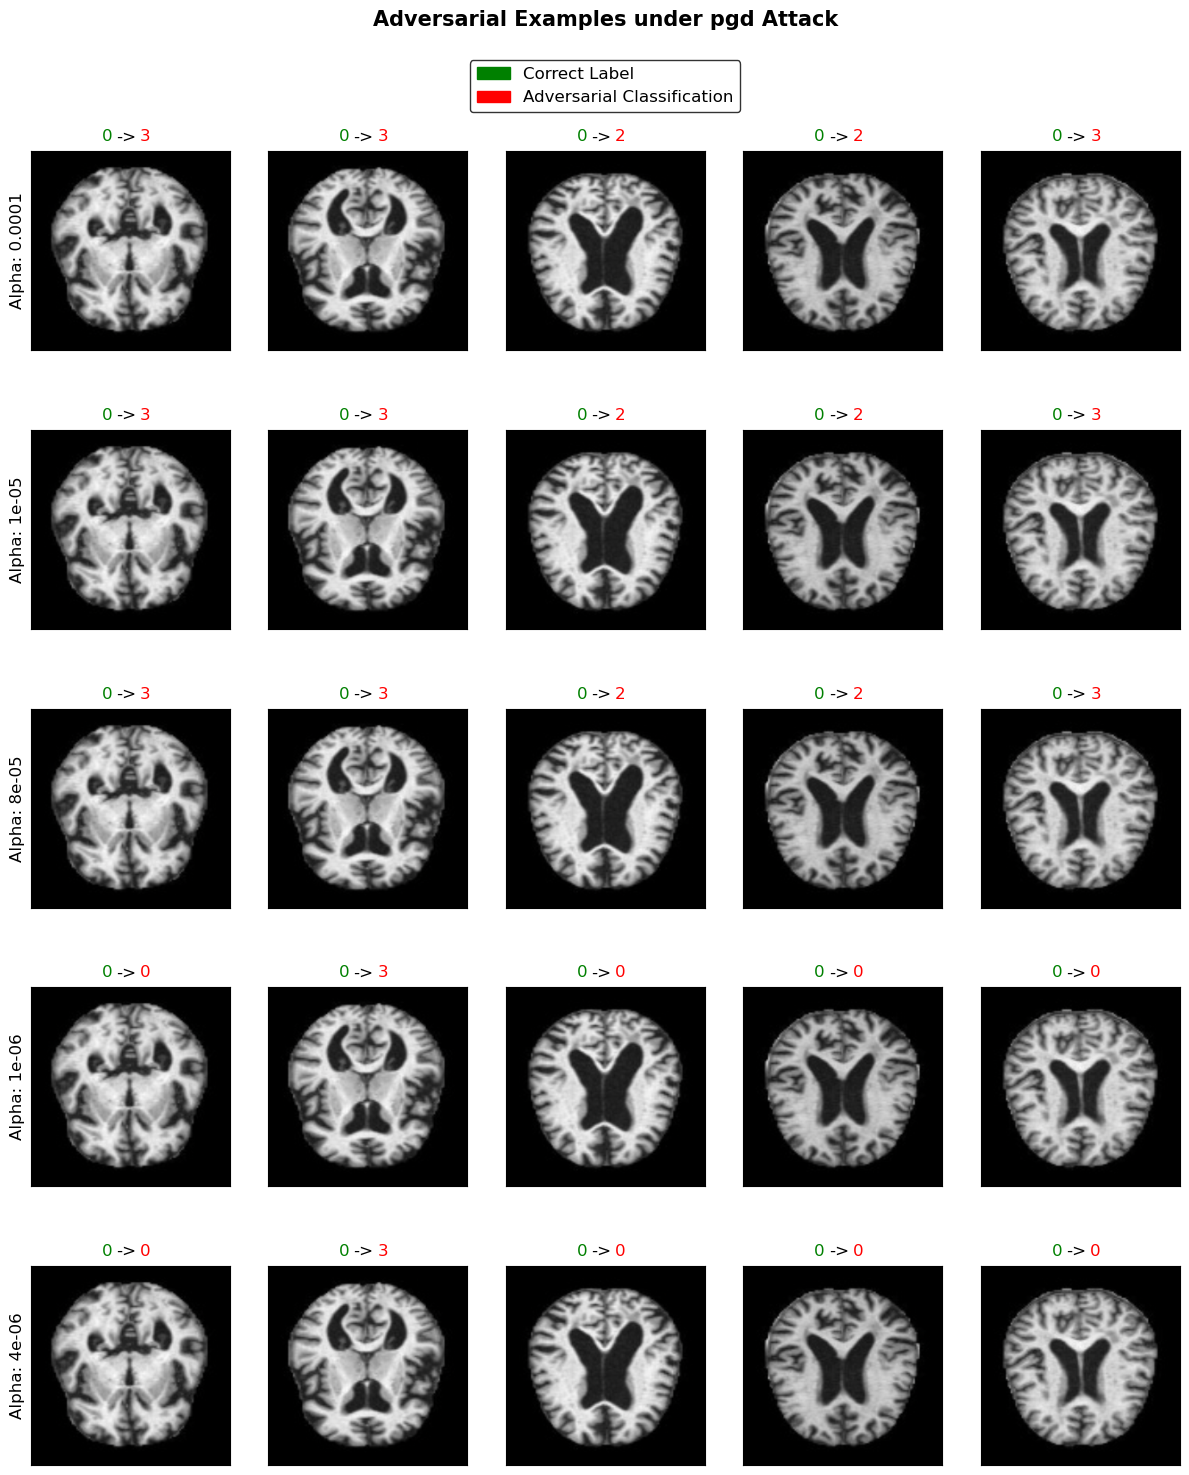

In [16]:
utils_funcs.plot_adversarial_examples(alphas, examples , attack_name='pgd', parameter_type = 'Alpha')

**Train Robust Model Against Adversarial Attacks**

In [18]:
# Set hyper-parameters
num_epochs = 35
train_epsilon = epsilon = 0.0005
alpha = 0.0001
adv_weight = 0.5
num_iter = 5

# Data loading and shuffling
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [19]:
augmentations = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.1),
    K.RandomVerticalFlip(p=0.1),
    K.RandomRotation(degrees=10, p=0.1),
    K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.1),
    K.RandomBrightness(brightness=(0.8, 1.2), p=0.1),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.1),
    K.RandomGamma(gamma=(0.9, 1.1), p=0.1),
    K.RandomSharpness(p=0.1),
    same_on_batch=False
)

In [14]:
load_existing_params = False
train_loaded_model = False

if load_existing_params:
    model_path = './checkpoints/DINOv2_atk_225702_10102024/DINOv2_atk_120234_12102024_train_0.2628_val_0.5694.pth'
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['net'])
        
    if(train_loaded_model):
        epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies =  utils_funcs.adversarial_train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer,'pgd', epsilon = epsilon, adv_weight = adv_weight,
                                                                                                                                           alpha = alpha,num_iter=num_iter, kornia_aug=augmentations, use_amp=True, scheduler=scheduler) 
    else:
        # Load the saved values from the checkpoint
        epoch_train_losses = checkpoint['train_epoch_losses']
        epoch_validation_losses = checkpoint['validation_epoch_losses']
        epoch_train_accuracies = checkpoint['train_epoch_accuracies']
        epoch_validation_accuracies = checkpoint['validation_epoch_accuracies']      
        num_epochs = checkpoint['epoch'] 
        
else:    
    epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.adversarial_train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer,'pgd', epsilon = epsilon, adv_weight = adv_weight,
                                                                                                                                           alpha = alpha,num_iter=num_iter, kornia_aug=augmentations, use_amp=True, scheduler=scheduler)                                                                                                                    

Adversarial Training model: EfficientNet_atk on cuda:0 with PGD attack and adversarial weight 0.5
Created training session directory: ./checkpoints/EfficientNet_atk_083728_15102024


Training:   0%|          | 0/32 [00:00<?, ?it/s]

**Results**

In [15]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy on regular test set: {:.3f}%".format(test_accuracy))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='fgsm',epsilon=train_epsilon)
print("Test accuracy on adversial attacks using FGSM method: {:.3f}%".format(test_accuracy_adversial_attk))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='pgd',epsilon=train_epsilon, alpha=alpha, num_iter=num_iter)
print("Test accuracy on adversial attacks using PGD method: {:.3f}%".format(test_accuracy_adversial_attk))

Test accuracy on regular test set: 92.025%
Test accuracy on adversial attacks using FGSM method: 41.673%
Test accuracy on adversial attacks using PGD method: 72.478%


<Figure size 800x600 with 0 Axes>

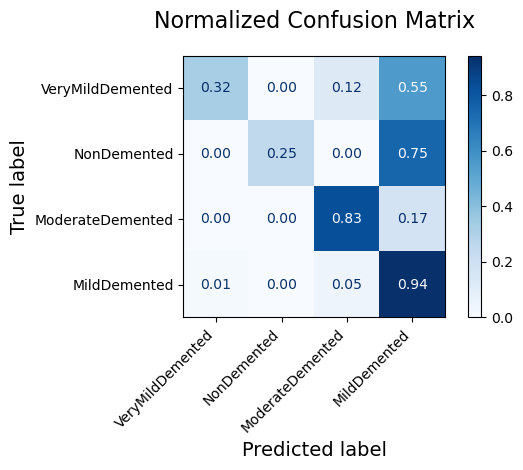

In [28]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_normalized_confusion_matrix(testloader, model, class_names, device, model_name)

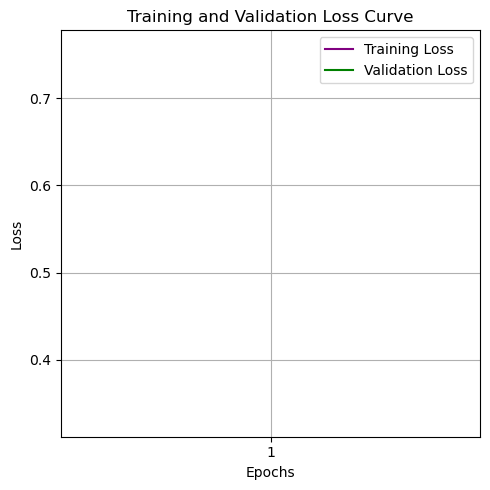

In [29]:
utils_funcs.plot_loss_curve(epoch_train_losses, epoch_validation_losses, num_epochs, model_name)

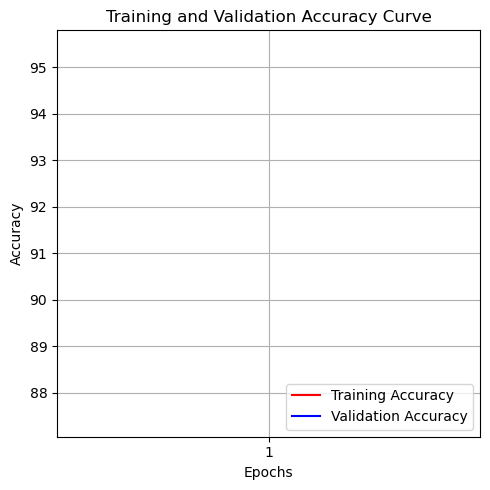

In [30]:
utils_funcs.plot_accuracy_curve(epoch_train_accuracies, epoch_validation_accuracies, num_epochs, model_name)